# Frauenhofer diffraction and Fourier filtering

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
%matplotlib inline  
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [20, 10]

# Functions to make it easy to draw patterns on the aperture.

In [2]:
#c = 3e8 # m/s

def inboxA(screen,center,fullwidth):
    # screen must be 2D square numpy array.
    # center must be a tuple, (xcenter,ycenter)
    n_elements = screen.shape[0]
    xmin = center[0] - fullwidth/2
    xmax = center[0] + fullwidth/2
    ymin = center[1] - fullwidth/2
    ymax = center[1] + fullwidth/2
    for x in range(n_elements):
        for y in range(n_elements):
            if ( (x>xmin) and (x<xmax) and (y>ymin) and (y<ymax)):
                screen[x,y] = 1
    return screen

def incircleA(screen,center,radius):
    # screen must be 2D square numpy array.
    # center must be a tuple, (xcenter,ycenter)
    n_elements = screen.shape[0]
    x0 = center[0]
    y0 = center[1]
    for x in range(n_elements):
        for y in range(n_elements):
            rpix = np.sqrt( (x-x0)**2 + (y-y0)**2)
            if ( rpix < radius):
                screen[x,y] = 1
    return screen

def gaussian(screen, center, sigma):
    # screen must be 2D square numpy array.
    # This routine adds a gaussian to it.
    # center must be a tuple, (xcenter,ycenter)
    x0 = center[0]
    y0 = center[1]
    n_elements = screen.shape[0]
    for x in range(n_elements):
        for y in range(n_elements):
            rpix = np.sqrt( (x-x0)**2 + (y-y0)**2)
            val = np.exp(-(rpix**2)/(2*sigma**2))
            screen[x,y] += val
    return screen


def xslit(screen,xcenter,halfwidth):
    # This sets screen values to 1 in the slit;  it leaves the rest unchanged.
    n_elements = screen.shape[0]
    for x in range(n_elements):
        for y in range(n_elements):
            if np.abs(x-xcenter)<halfwidth:
                screen[x,y] = 1
    return screen

def yslit(screen,ycenter,halfwidth):
    # This sets screen values to 1 in the slit;  it leaves the rest unchanged.
    n_elements = screen.shape[0]
    for x in range(n_elements):
        for y in range(n_elements):
            if np.abs(y-ycenter)<halfwidth:
                screen[x,y] = 1
    return screen

def slitgrid(screen, nslits, halfwidth):
    xlocations = np.linspace(0,screen.shape[0],nslits).astype(int)
    ylocations = np.linspace(0,screen.shape[1],nslits).astype(int)
    for xloc in xlocations:
        xslit(screen,xloc,halfwidth)
    for yloc in ylocations:
        yslit(screen,yloc,halfwidth)
    return screen

# Set up the size and resolution fo the aperture, the wavelength, etc.

In [3]:
# Set up details of system
D_ap = 0.1  # meters, size of the aperture screen 
xmax = D_ap/2.
lam = 0.003   # meters, wavelength of light
k = 2*np.pi/lam  # k-vector of incident light
dk = 1/D_ap    # transverse k_vector bin width

# We need to find the maximum value of k_x and k_y allowed.
# We will do the FFT, then discard values of higher k_x, k_y than this
# Or maybe higher k_transverse than this.
theta_max = np.pi/2.
k_xmax = k*np.sin(theta_max)  # same as k_ymax

# Create a screen, FFT it, and plot both.

k0 =  2094.3951023931954


Text(0.5, 1.0, 'k-plane (log10)')

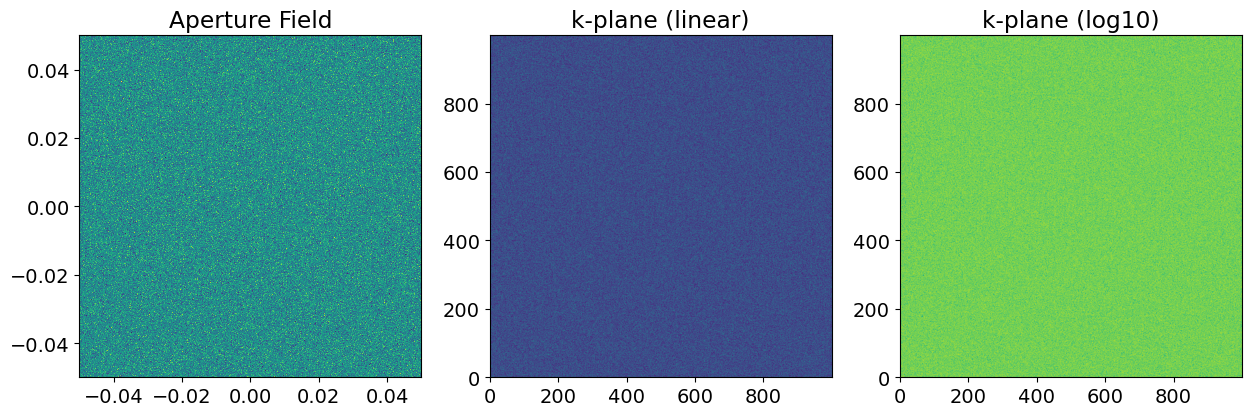

In [26]:
# Now set up the aperture
N = 1000   # resolution elements across the aperture
screen = np.zeros((N,N))


# Y-oriented slits
#screen = yslit(screen,500,6)
#screen = yslit(screen,550,6)

# A square box
#screen = inboxA(screen,(500,500),20)
#screen = inboxA(screen,(500,400),20)

screen = incircleA(screen,(500,500),10) + np.random.normal(scale=1.0,size=(N,N))
#screen = incircleA(screen,(500,550),10) #+ np.random.normal(scale=0.1,size=(N,N))

#screen = gaussian(screen, (500,500),3)
#screen = gaussian(screen, (500,460),3)

#screen = slitgrid(screen, 10, 2)
#screen = np.abs(1-screen)


# Fourier transform gives kx,ky vector amplitudes, corresponding to thetas above.
#
E_beam = np.fft.fftshift(np.fft.fft2(screen))

plt.rcParams['figure.figsize'] = [15, 6]
plt.clf()
#
plt.subplot(1,3,1)
plt.imshow(screen,origin='lower', interpolation='None',extent = [-xmax,xmax,-xmax,xmax])
plt.title('Aperture Field')
#
kmax = k_xmax
plt.subplot(1,3,2)
plt.imshow(np.abs(E_beam),origin='lower')#,interpolation='None')#,extent=[-kmax,kmax,-kmax,kmax])
#plt.colorbar()
plt.title('k-plane (linear)')
print('k0 = ',k)
#
plt.subplot(1,3,3)
deg_max = theta_max*180/np.pi
plt.imshow(np.log10(np.abs(E_beam)+1e-2),origin='lower')#,interpolation='None')#,extent=[-deg_max,deg_max,-deg_max,deg_max])
#plt.colorbar()
plt.title('k-plane (log10)')

# Create a Fourier Filter

In [27]:
n_elements = screen.shape[0]
kvec = dk*np.fft.fftfreq(n_elements)*n_elements # renormalize fftfreq grid 
#
# Generate 2D array of kx and ky values for each point in the k_plane
kx_array = np.fft.fftshift(np.tile(kvec,(kvec.size,1)))
ky_array = kx_array.transpose()

x0 = N/2
y0 = N/2

# Create filter in fourier space
filter_t = 0*kx_array
filter_t = incircleA(filter_t,(x0,y0),N/20)

# Filter the k-space E
E_beam_f = E_beam*filter_t

# ifft to get the filtered image
transform_image = np.fft.ifft2(np.fft.fftshift(E_beam_f))

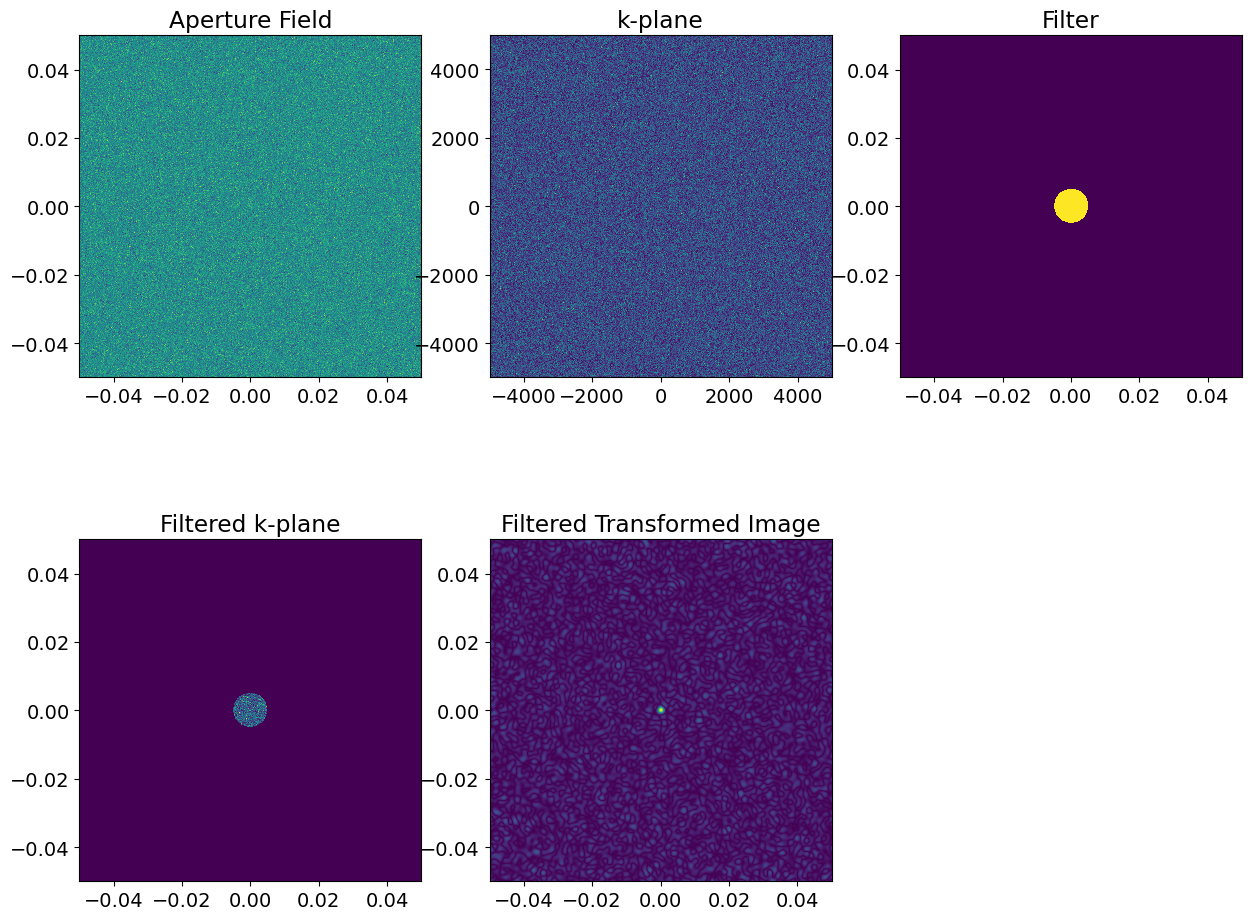

In [28]:
# plotting
plt.rcParams['figure.figsize'] = [15, 12]
plt.figure(1)
plt.clf()
#
# Show original image
plt.subplot(231)
plt.imshow(screen,origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Aperture Field')
#
# Fourier transform of image
kmax = np.max(kvec)
plt.subplot(232)
plt.imshow(np.abs(E_beam),origin='lower',interpolation='none',extent=[-kmax,kmax,-kmax,kmax])
plt.title('k-plane')
#
# Filter we're going to apply
plt.subplot(233)
plt.imshow(filter_t,origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Filter')
#
# Filtered Fourier transform of image
plt.subplot(234)
plt.imshow(np.abs(E_beam_f),origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Filtered k-plane')
#
# ifft to get filtered image
plt.subplot(235)
plt.imshow(np.abs(transform_image),origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Filtered Transformed Image')

plt.show()


# Gaussian

500.0
500.0
1000


(1000, 1000)

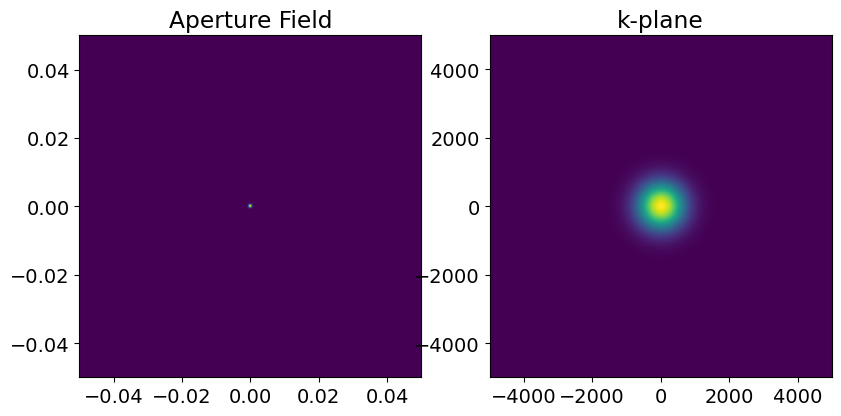

In [9]:
screen = np.zeros((N,N))
sigma_elements = N/300.
x0 = N/2
y0 = x0

screen = gaussian(screen, (x0,y0),sigma_elements)
E_beam = np.fft.fftshift(np.fft.fft2(screen))
plt.clf()
#
plt.subplot(231)
plt.imshow(screen,origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Aperture Field')
#
kmax = np.max(kvec)
plt.subplot(232)
plt.imshow(np.abs(E_beam),origin='lower',interpolation='none',extent=[-kmax,kmax,-kmax,kmax])
plt.title('k-plane')

print(x0)
print(y0)
print(N)
screen.shape